# Pinball

In [1]:
#IMPORT LIBRARIES

from dolfin import *
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from __future__ import print_function
from IPython.display import clear_output as clc

plt.style.use('default')
sys.path.append('../')
set_log_level(LogLevel.ERROR)

# Fokker-Planck equation

\begin{cases}
     \dfrac{\partial y}{\partial t} + \nabla \cdot (- \nu \nabla y + \mathbf{v}(\boldsymbol{\mu}) y) = 0 \qquad &\mathrm{in} \ \Omega \times (0,T)  \\
             (-\nu \nabla y + \mathbf{v}(\boldsymbol{\mu}) y) \cdot \mathbf{n} = 0  \qquad &\mathrm{on} \ \partial \Omega  \times (0,T) \\
       y(0) = \bar{y} \qquad &\mathrm{in} \ \Omega \times \{t = 0\}
\end{cases}


where $\Omega$ is the domain of interest (visualised below) with boundary $\partial \Omega$, $T>0$ is the final time, $y: \Omega \times [0,T] \to \mathbb R$ is the unknown state field, $\mathbf{v}(\boldsymbol{\mu}):\Omega \to \mathbb R^2$ is the fluid flow velocity field computed via steady Navier-Stokes dependent on the parameters $\boldsymbol{\mu}$ in the parameter space $\mathcal{P}$, $\nu$ is the diffusion coefficient, $\mathbf{n}$ is the normal versor and $\bar{y}$ is the initial datum

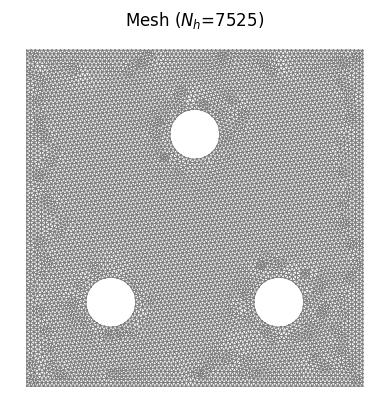

In [2]:
# LOAD THE MESH FOR THE STATE PROBLEM

mesh = Mesh("Data/Pinball_Pinball_mesh.xml")

plot(mesh, color = "grey", linewidth = 0.75)
plt.title("Mesh ($N_{h}$=%d)" % mesh.num_vertices())
plt.axis("off");

In [3]:
# DEFINE MEASURES

dx = Measure("dx", domain = mesh)

class GammaOBS1(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        d = sqrt((x[0] + 0.5)*(x[0] + 0.5) + (x[1] + 0.5)*(x[1] + 0.5))
        return on_boundary and d <= 0.15 + DOLFIN_EPS
class GammaOBS2(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        d = sqrt((x[0] - 0.5)*(x[0] - 0.5) + (x[1] + 0.5)*(x[1] + 0.5))
        return on_boundary and d <= 0.15 + DOLFIN_EPS
class GammaOBS3(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        d = sqrt(x[0]*x[0] + (x[1] - 0.5)*(x[1] - 0.5))
        return on_boundary and d <= 0.15 + DOLFIN_EPS
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
GammaOBS1().mark(boundaries, 1)
GammaOBS2().mark(boundaries, 2)
GammaOBS3().mark(boundaries, 3)

ds = Measure("ds", domain = mesh, subdomain_data = boundaries)

In [4]:
# DEFINE THE STATE SPACE

Yh = FunctionSpace(mesh, "CG", 1)
nstate = Yh.dim()

In [5]:
# DEFINE THE FLUID FLOW VELOCITY AND PRESSURE SPACES

Vh = VectorElement('CG', mesh.ufl_cell(), 2)
Ph = FiniteElement('CG', mesh.ufl_cell(), 1)
VPh = FunctionSpace(mesh, Vh * Ph)
Vh = VPh.sub(0).collapse()
Ph = VPh.sub(1).collapse()

nvelocity = Vh.dim()
npressure = Ph.dim()

In [6]:
# DEFINE THE STATE PROBLEM SOLVER

from tqdm import tqdm

diffusion = 0.001 # State diffusion coefficient
nu = 1.0          # Fluid viscosity
h = 0.05          # Mesh step size
eps = 1e-8        # Nitsche's method parameter

def gaussian_generator(params):
    """
    Generate a 2D Gaussian starting from the mean position
    Input: mean coordinate
    Output: 2D Gaussian function
    """
    y0 = Expression('10 / pi * exp(- 10*(x[0] - x0)*(x[0] - x0) - 10*(x[1] - x1)*(x[1] - x1))', degree = 1, x0 = params[0], x1 = params[1])
    return interpolate(y0, Yh)

def compute_velocity(params):
    """
    Compute steady Navier-Stokes velocity via Newton method
    Input: inflow velocity parameters
    Output: steady Navier-Stokes velocity
    """
    
    n = FacetNormal(mesh)
    t = as_vector([n[1], -n[0]])

    # Free-slip BC on the wall
    wall = DirichletBC(VPh.sub(0), (0.0, 0.0), "on_boundary && (x[0] >= 0.9 || x[0] < -0.9 || x[1] < -0.9 || x[1] > 0.9)")

    # Solve state equation
    w, q = TestFunctions(VPh)
    vp = Function(VPh)
    v, p = split(vp)

    F = nu * inner(grad(v), grad(w)) * dx + dot(dot(grad(v), v), w) * dx - p * div(w) * dx - q * div(v) * dx + 1 / eps * inner(v, n) * inner(w, n) * (ds(1) + ds(2) + ds(3)) - 1 / eps * inner(v, t) * inner(w, t) * (ds(1) + ds(2) + ds(3)) + 1 / eps * params[0] * inner(w, t) * ds(1) + 1 / eps * params[1] * inner(w, t) * ds(2) + 1 / eps * params[2] * inner(w, t) * ds(3)
    solve(F == 0, vp, wall)
    v, p = vp.split(deepcopy=True)

    return v

def compute_state(v, y0, dt, ntimesteps):
    """
    Compute the state trajectory
    Input: initial condition, time step and number of timesteps
    Output: time-dependent solution of the Fokker-Planck equation
    """
   
    mod_in = project(v[1], Yh)(0,-1)

    yt = torch.zeros(ntimesteps + 1, nstate)
    yt[0] = torch.tensor(y0.vector())

    i = 0

    for i in tqdm(range(ntimesteps), colour = "cyan", file = sys.stdout, bar_format = 'Computing state |{bar}| {n}/{total} {elapsed}<{remaining}'):
        
        w = TestFunction(Yh)
        y = TrialFunction(Yh)

        a = inner(y, w) * dx + 0.5 * dt * (diffusion + mod_in * h / 2) * inner(grad(y), grad(w)) * dx - 0.5 * dt * y * project(v[0], Yh) * w.dx(0) * dx - 0.5 * dt * y * project(v[1], Yh) * w.dx(1) * dx
        L = inner(y0, w) * dx - 0.5 * dt * (diffusion + mod_in * h / 2) * inner(grad(y0), grad(w)) * dx + 0.5 * dt * y0 * project(v[0], Yh) * w.dx(0) * dx + 0.5 * dt * y0 * project(v[1], Yh) * w.dx(1) * dx
    
        y = Function(Yh)
        solve(a == L, y, DirichletBC(Yh, 0.0, "on_boundary"))
        
        y0.assign(y)
        yt[i+1] = torch.tensor(y.vector())
             
    return yt

In [7]:
# SOLVE THE STATE PROBLEM

dt = Constant(0.1)
T = 3.0
ntimesteps = round(T / dt)

params = [0.5, 0.5, 1.0]
v = compute_velocity(params)

y0 = gaussian_generator([0.0, 0.0])

yt = compute_state(v, y0, dt, ntimesteps)

Computing state |████████████████████████████████████████████| 30/30 00:05<00:00


In [8]:
# FUNCTION TO CONVERT VECTORS INTO FUNCTIONS

def vec2fun(yvec, Yh):
    '''
    Convert a vector into a fenics function
    Input: vector of degrees of freedom and functional space
    Output: function
    '''
    y = Function(Yh)
    y.vector()[:] = yvec
    return y

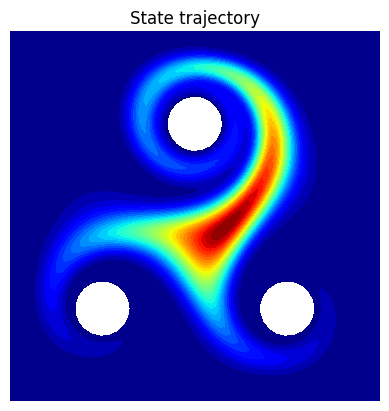

In [9]:
# STATE TRAJECTORY (PLOT)

from utils.processdata import trajectory

plot_state = lambda y: plot(vec2fun(y, Yh), cmap = "jet", vmin = 0.0, vmax = y.max())

trajectory(yt, plot_state, title = "State trajectory")

# Snapshots generation

In [ ]:
# GENERATE SNAPSHOTS (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

dt = Constant(0.1)
T = 3.0
ntimesteps = round(T / dt)
ntimes = ntimesteps + 1 # Time series length

ntrajectories = 500
nparams = 3

params_range = [(-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0)]

filename = 'Data/Pinball_Pinball_data'
Y = torch.zeros(ntrajectories, ntimes, nstate)
MU = torch.zeros(ntrajectories, ntimes, nparams)
VNS = torch.zeros(ntrajectories, nvelocity)

for i in range(ntrajectories):

    print(f"Generating snapshots n.{i}...")
    
    params = [0] * len(params_range)
    for j in range(len(params_range)):
        params[j] = ((params_range[j][1] - params_range[j][0]) * torch.rand(1) + params_range[j][0]).item()  
    
    v = compute_velocity(params)

    VNS[i] = torch.tensor(v.vector()[:])
    
    y0 = gaussian_generator([0.0, 0.0])

    yt = compute_state(v, y0, dt, ntimesteps)

    Y[i] = yt
    
    for j in range(ntimes):
        MU[i,j] = torch.tensor(params)

    clc(wait = True)

print("Snapshots generated!")

np.savez("%s.npz" % filename.replace(".npz",""), y = Y, mu = MU, v = VNS)

In [10]:
# LOAD SNAPSHOTS MATRICES

dt = Constant(0.1)
T = 3.0
ntimesteps = round(T / dt)
ntimes = ntimesteps + 1 # Time series length

ntrajectories = 500
nparams = 3

params_range = [(-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0)]

filename = 'Data/Pinball_Pinball_data'
Data = np.load("%s.npz" % filename.replace(".npz",""))
Y = torch.tensor(Data["y"])[:,:ntimes]
MU = torch.tensor(Data["mu"])[:,:ntimes]
VNS = torch.tensor(Data["v"])

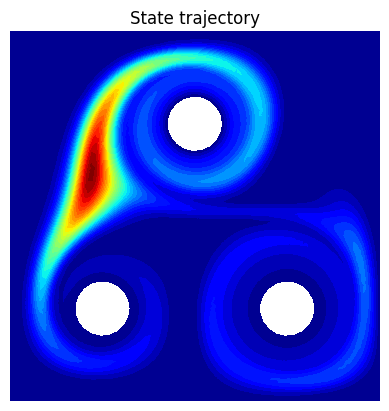

In [11]:
# TRAJECTORY EXAMPLE (PLOT)

trajectory(Y[-1], plot_state, title = "State trajectory")

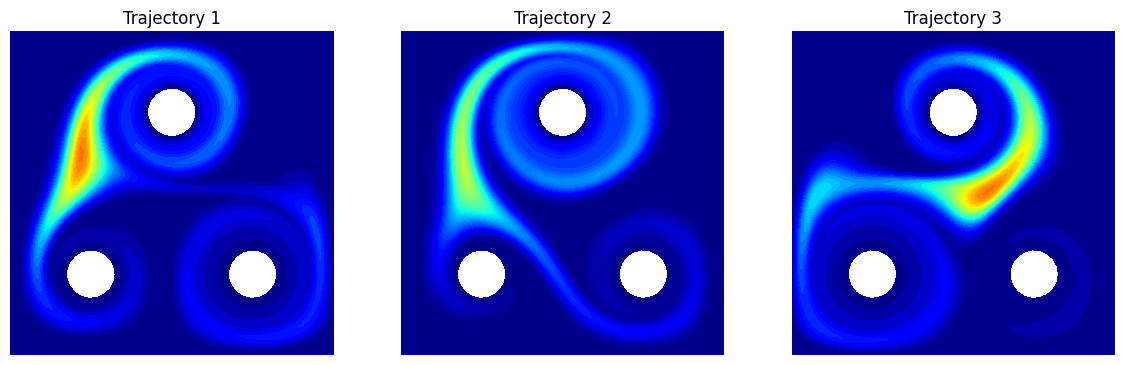

In [13]:
# TRAJECTORY EXAMPLES (PLOT)

from utils.processdata import trajectories

which = (-1, -2, -3)

plotlist = [Y[which[0]], Y[which[1]], Y[which[2]]]
vmax = max(plotlist[i].max() for i in range(len(plotlist)))
plot_state_in_list = lambda y : plot(vec2fun(y, Yh), cmap = "jet", vmin = 0.0, vmax = vmax)

trajectories(plotlist, plot_state_in_list, titles = ("Trajectory 1", "Trajectory 2", "Trajectory 3"), figsize = (100, 100))

In [14]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed(0)

ntrain = round(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

Ytrain = Y[idx_train]
Yvalid = Y[idx_valid]
Ytest = Y[idx_test]
MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]

# State reduction - POD

In [15]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mre, num2p # Error metrics and format

In [16]:
# RESHAPE MATRICES

Ytrain = Ytrain.reshape(-1, nstate).numpy()
Yvalid = Yvalid.reshape(-1, nstate).numpy()
Ytest = Ytest.reshape(-1, nstate).numpy()

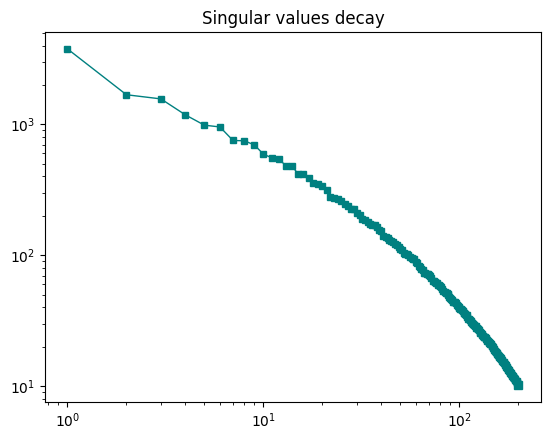

In [17]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Y

from sklearn.utils.extmath import randomized_svd

kstate = 200 # Number of POD modes

U, S, V = randomized_svd(Ytrain, n_components = kstate)

teal = sns.light_palette("teal", 15)
plt.plot([i for i in range(1, kstate + 1)], S, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kstate, S[kstate-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay");

Ytrain_POD = Ytrain @ V.transpose()
Yvalid_POD = Yvalid @ V.transpose()
Ytest_POD = Ytest @ V.transpose()
Ytrain_reconstructed = U @ np.diag(S) @ V
Yvalid_reconstructed = Yvalid @ V.transpose() @ V
Ytest_reconstructed = Ytest @ V.transpose() @ V

In [18]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("Mean relative POD reconstruction error on Y: %s" % num2p(mre(torch.from_numpy(Ytest), torch.from_numpy(Ytest_reconstructed))))

Mean relative POD reconstruction error on Y: 1.54%


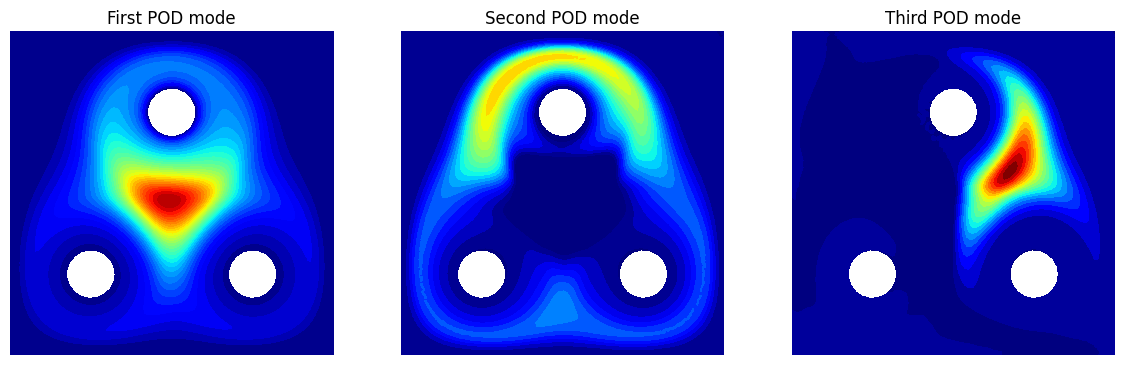

In [20]:
# POD MODES (PLOT)

from utils.processdata import multiplot

plotlist = [V[0], V[1], V[2]]
vmax = max(plotlist[i].max() for i in range(len(plotlist)))

multiplot(plotlist, plot_state_in_list, titles = ("First POD mode", "Second POD mode", "Third POD mode"), figsize = (100, 100))

In [21]:
# RESHAPE MATRICES

Ytrain = torch.from_numpy(Ytrain.reshape(ntrain, ntimes, nstate))
Yvalid = torch.from_numpy(Yvalid.reshape(nvalid, ntimes, nstate))
Ytest = torch.from_numpy(Ytest.reshape(ntest, ntimes, nstate))
Ytrain_POD = torch.from_numpy(Ytrain_POD.reshape(ntrain, ntimes, kstate))
Yvalid_POD = torch.from_numpy(Yvalid_POD.reshape(nvalid, ntimes, kstate))
Ytest_POD = torch.from_numpy(Ytest_POD.reshape(ntest, ntimes, kstate))
Ytrain_reconstructed = torch.from_numpy(Ytrain_reconstructed.reshape(ntrain, ntimes, nstate))
Yvalid_reconstructed = torch.from_numpy(Yvalid_reconstructed.reshape(nvalid, ntimes, nstate))
Ytest_reconstructed = torch.from_numpy(Ytest_reconstructed.reshape(ntest, ntimes, nstate))

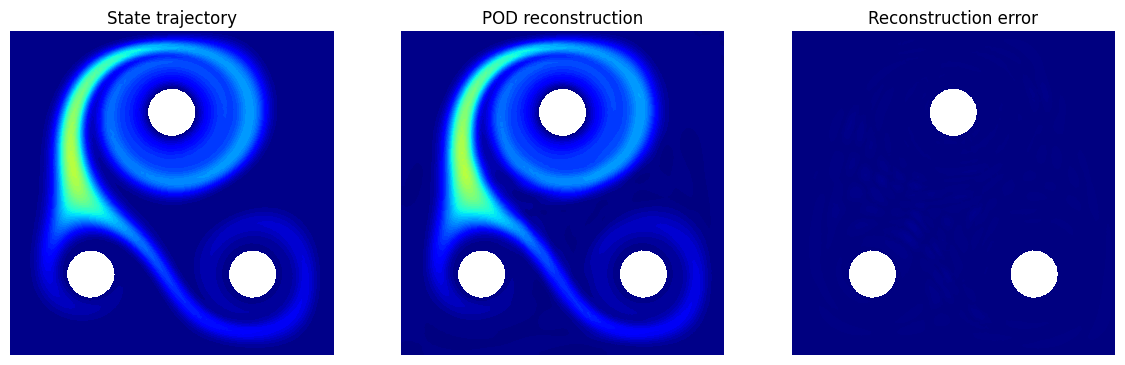

In [24]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -1

plotlist = [Ytest[which], Ytest_reconstructed[which], np.sqrt((Ytest[which] - Ytest_reconstructed[which])**2)]
vmax = max(plotlist[i].max() for i in range(len(plotlist)))

trajectories(plotlist, plot_state_in_list, titles = ("State trajectory", "POD reconstruction", "Reconstruction error"), figsize = (100, 100))

# SHRED-ROM

## Fixed sensors

In [23]:
# EXTRACT SENSORS DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

nsensors = 3
idx_sensors = np.random.choice(nstate, size = nsensors, replace = False)
sensors_coordinates = torch.from_numpy(Yh.tabulate_dof_coordinates()[idx_sensors]).reshape(-1)

sensors_data_train = Ytrain[:,:,idx_sensors]
sensors_data_valid = Yvalid[:,:,idx_sensors]
sensors_data_test = Ytest[:,:,idx_sensors]

In [25]:
# LOAD SENSORS DATA

nsensors = 3
idx_sensors = torch.load('Data/Pinball_idx_fixedsensors.pt', weights_only=False)
sensors_coordinates = torch.from_numpy(Yh.tabulate_dof_coordinates()[idx_sensors]).reshape(-1)

sensors_data_train = Ytrain[:,:,idx_sensors]
sensors_data_valid = Yvalid[:,:,idx_sensors]
sensors_data_test = Ytest[:,:,idx_sensors]

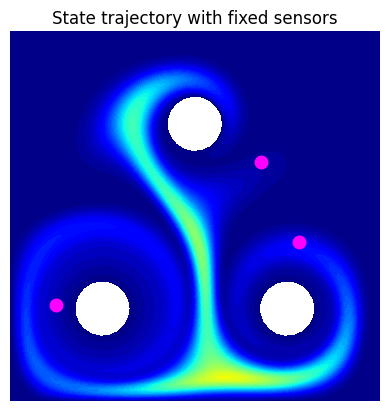

In [26]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_fixedsensors(yt, sensors_coordinates, title = None):
    """
    State trajectory with moving sensor
    Input: state trajectory with dimension (ntimes, nstate) and sensors coordinates with dimension (ntimes, 2 * nsensors)
    """

    vmax = yt.max()
    
    for i in range(yt.shape[0]):
        plot(vec2fun(yt[i], Yh), cmap = "jet", vmin = 0.0, vmax = vmax)
        for k in np.arange(0, nsensors * 2, 2):
            plt.plot(sensors_coordinates[k], sensors_coordinates[k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

which = 0

trajectory_with_fixedsensors(Y[which], sensors_coordinates, title = "State trajectory with fixed sensors")

In [27]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 10

train_data_in = Padding(torch.cat((sensors_data_train, MUtrain), 2), lag).to(device)
valid_data_in = Padding(torch.cat((sensors_data_valid, MUvalid), 2), lag).to(device)
test_data_in = Padding(torch.cat((sensors_data_test, MUtest), 2), lag).to(device)

train_data_out = Padding(Ytrain_POD, 1).squeeze(1).to(device)
valid_data_out = Padding(Yvalid_POD, 1).squeeze(1).to(device)
test_data_out = Padding(Ytest_POD, 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [27]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(nsensors + nparams, kstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

In [28]:
# SHRED LOADING

from utils.models import SHRED, fit

shred = SHRED(nsensors + nparams, kstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('NN/Pinball_shred_fixedsensors.pt', weights_only = True));

In [29]:
# SHRED ERRORS ON TEST DATA

shred.freeze()

Ytest_POD_hat = shred(test_data_in).cpu()
Ytest_hat = (Ytest_POD_hat @ V).reshape(ntest, ntimes, nstate)

print("Mean relative SHRED prediction error on Y: %s" % num2p(mre(Ytest_hat, Ytest)))

Mean relative SHRED prediction error on Y: 9.24%


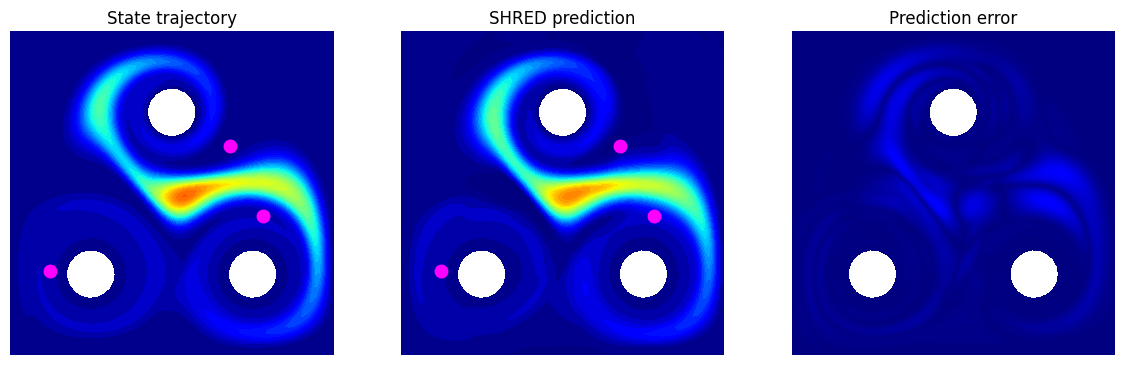

In [30]:
# FOM vs SHRED PREDICTION (PLOTS)

def trajectories_with_fixedsensors(yts, sensors_coordinates, titles = None):
    """
    Trajectories with moving sensor
    Input: list of trajectories with dimension (ntimes, nstate) and sensors coordinates with dimension (ntimes, 2 * nsensors)
    """

    for i in range(yts[0].shape[0]):
    
        vmax = max(yts[j].max() for j in range(len(yts)))

        plt.figure(figsize = (100, 100))
        for j in range(len(yts)):
            plt.subplot(20, 20, j+1)
            plot(vec2fun(yts[j][i], Yh), cmap = "jet", vmin = 0.0, vmax = vmax)
            if j < len(yts)-1:
               for k in np.arange(0, nsensors * 2, 2):
                   plt.plot(sensors_coordinates[k], sensors_coordinates[k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
            plt.title(titles[j])
            plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

which = 0

plotlist = [Ytest[which], Ytest_hat[which], ((Ytest[which] - Ytest_hat[which])**2).sqrt()]

trajectories_with_fixedsensors(plotlist, sensors_coordinates, titles = ("State trajectory", "SHRED prediction", "Prediction error"))

## Moving sensors

In [31]:
# EXTRACT SENSOR COORDINATES (SKIP THIS CELL IF COORDINATES ALREADY AVAILABLE)

nsensors = 3
sensors_coordinates = torch.zeros(ntrajectories, ntimes, nsensors * 2) # Sensors coordinates for every trajectory

for i in range(ntrajectories):
    v = vec2fun(VNS[i], Vh)
    v.set_allow_extrapolation(True)
    for j in range(ntimes):
        for k in np.arange(0, nsensors * 2, 2):
            if j == 0:
                initial_coordinates = torch.from_numpy(Yh.tabulate_dof_coordinates()[np.random.choice(nstate, size = nsensors, replace = False)]).reshape(-1)
                sensors_coordinates[i,j] = initial_coordinates
            else:
                sensors_coordinates[i,j,k:k+2] = sensors_coordinates[i,j-1,k:k+2] + float(dt) * v(sensors_coordinates[i,j-1,k:k+2])

In [32]:
# LOAD SENSOR COORDINATES

nsensors = 3
sensors_coordinates = torch.load('Data/Pinball_movingsensors_coordinates_diff_init.pt', weights_only = True)

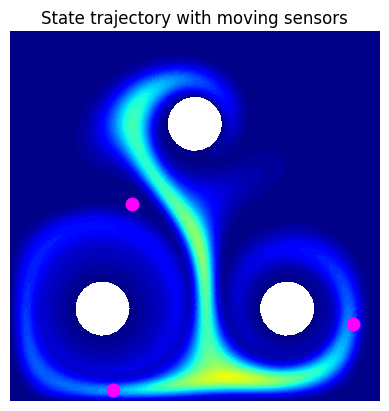

In [33]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_movingsensors(yt, sensors_coordinates, title = None):
    """
    State trajectory with moving sensor
    Input: state trajectory with dimension (ntimes, nstate) and sensors coordinates with dimension (ntimes, 2 * nsensors)
    """

    vmax = yt.max()
    
    for i in range(yt.shape[0]):
        plot(vec2fun(yt[i], Yh), cmap = "jet", vmin = 0.0, vmax = vmax)
        for k in np.arange(0, nsensors * 2, 2):
            plt.plot(sensors_coordinates[i,k], sensors_coordinates[i,k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

which = 0

trajectory_with_movingsensors(Y[which], sensors_coordinates[which], title = "State trajectory with moving sensors")

In [34]:
# TRAIN-VALIDATION-TEST SPLITTING

sensors_coordinates_train = sensors_coordinates[idx_train]
sensors_coordinates_valid = sensors_coordinates[idx_valid]
sensors_coordinates_test = sensors_coordinates[idx_test]

In [35]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 30

train_data_in = Padding(torch.cat((sensors_coordinates_train, MUtrain), 2), lag).to(device)
valid_data_in = Padding(torch.cat((sensors_coordinates_valid, MUvalid), 2), lag).to(device)
test_data_in = Padding(torch.cat((sensors_coordinates_test, MUtest), 2), lag).to(device)

train_data_out = Padding(Ytrain_POD, 1).squeeze(1).to(device)
valid_data_out = Padding(Yvalid_POD, 1).squeeze(1).to(device)
test_data_out = Padding(Ytest_POD, 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [33]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(2 * nsensors + nparams, kstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

In [36]:
# SHRED LOADING

from utils.models import SHRED, fit

shred = SHRED(2 * nsensors + nparams, kstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load( 'NN/Pinball_shred_movingsensors_coords_only.pt', weights_only = False));

In [37]:
# SHRED ERRORS ON TEST DATA

shred.freeze()

Ytest_POD_hat = shred(test_data_in).cpu()
Ytest_hat = (Ytest_POD_hat @ V).reshape(ntest, ntimes, nstate)

print("Mean relative SHRED prediction error on Y: %s." % num2p(mre(Ytest_hat, Ytest)))

Mean relative SHRED prediction error on Y: 8.45%.


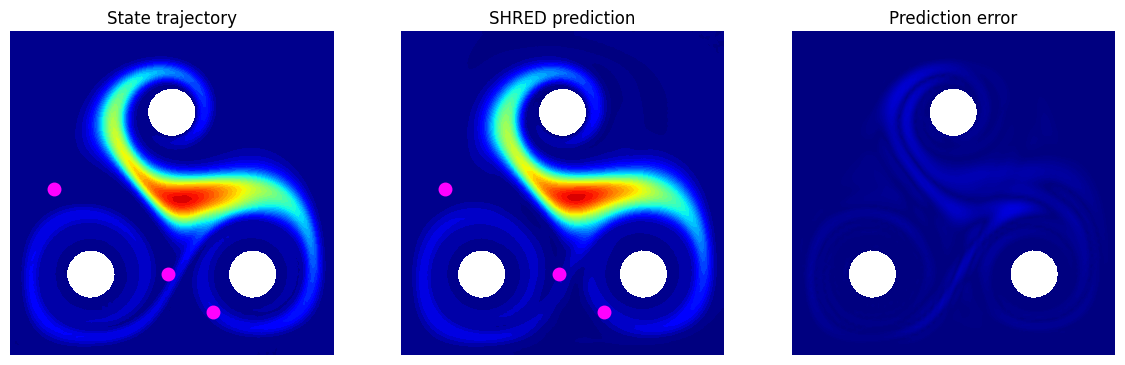

In [ ]:
# FOM vs SHRED PREDICTION (PLOTS)

def trajectories_with_movingsensors(yts, sensors_coordinates, colorbar = False, shrink = 1, format = "%0.2f", titles = None):
    """
    Trajectories with moving sensor
    Input: list of trajectories with dimension (ntimes, nstate) and sensors coordinates with dimension (ntimes, 2 * nsensors)
    """

    for i in range(yts[0].shape[0]):
    
        vmax = max(yts[j].max() for j in range(len(yts)))

        plt.figure(figsize = (100, 100))
        for j in range(len(yts)):
            plt.subplot(20, 20, j+1)
            plot(vec2fun(yts[j][i], Yh), cmap = "jet", vmin = 0.0, vmax = vmax)
            if j < len(yts)-1:
               for k in np.arange(0, nsensors * 2, 2):
                   plt.plot(sensors_coordinates[i,k], sensors_coordinates[i,k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
            plt.title(titles[j])
            plt.axis('off')
        
        display(plt.gcf())
        plt.close()
        clc(wait=True)

which = 0

plotlist = [Ytest[which], Ytest_hat[which], ((Ytest[which] - Ytest_hat[which])**2).sqrt()]

trajectories_with_movingsensors(plotlist, sensors_coordinates[which], titles = ("State trajectory", "SHRED prediction", "Prediction error"))